In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas
%matplotlib inline

ImportError: libpoppler.so.71: cannot open shared object file: No such file or directory

## Load Data

#### Synthetic Data

In [2]:
store = pd.HDFStore('/home/data/spring_2019/base/model_data.h5')

In [3]:
jobs = store['jobs']
bldgs = store['buildings']
parcels = store['parcels']

In [4]:
jobs_bldgs = pd.merge(jobs, bldgs, left_on='building_id', right_index=True)

In [5]:
jobs_bldgs_parcels = pd.merge(jobs_bldgs, parcels, left_on='parcel_id', right_index=True)

In [6]:
jobs_blocks = jobs_bldgs_parcels[['block_id']]

In [7]:
del jobs, bldgs, parcels, jobs_bldgs, jobs_bldgs_parcels

#### LODES Data

In [8]:
lodes_job_block_counts = pd.read_csv(
    '../../fall-2018-models/data/ca_wac_S000_JT01_2011.csv.gz',
    dtype={'w_geocode': str}, usecols=['w_geocode', 'C000'],
    compression='gzip'
).rename(columns={'C000': 'jobs'})

In [9]:
lodes_job_block_counts['county'] = lodes_job_block_counts['w_geocode'].str[2:5]

In [10]:
lodes_job_block_counts = lodes_job_block_counts[lodes_job_block_counts['county'].isin([
    '001', '013', '041', '055', '075', '081', '085', '095', '097'])]

## Compare Jobs Distributions by Census Tract

#### Synthetic Jobs

In [11]:
jobs_blocks['tract'] = jobs_blocks['block_id'].str[0:11]
jobs_tracts = jobs_blocks[['tract']]

In [12]:
synth_job_tract_counts = jobs_tracts.reset_index().groupby('tract').count().rename(columns={'job_id': 'jobs'})
synth_job_tract_counts['pct_jobs'] = synth_job_tract_counts['jobs'] / synth_job_tract_counts['jobs'].sum()

In [13]:
synth_job_tract_counts.shape

(1581, 2)

#### LEHD Jobs

In [14]:
lodes_job_block_counts['tract'] = lodes_job_block_counts['w_geocode'].str[:11]
lodes_jobs_tracts = lodes_job_block_counts[['jobs', 'tract']]

In [15]:
lodes_jobs_tract_counts = lodes_jobs_tracts.groupby('tract').sum()

In [16]:
lodes_jobs_tract_counts['pct_jobs'] = lodes_jobs_tract_counts['jobs'] / lodes_jobs_tract_counts['jobs'].sum()

In [17]:
lodes_jobs_tract_counts.shape

(1580, 2)

#### Merge

In [18]:
merged_job_tract_counts = pd.merge(
    lodes_jobs_tract_counts, synth_job_tract_counts, how='outer', on='tract', suffixes=('_lodes', '_synth'))

In [19]:
num_synth_not_in_lodes = len(merged_job_tract_counts[pd.isnull(merged_job_tract_counts.jobs_lodes)])
num_jobs_where_synth_not_in_lodes = merged_job_tract_counts[
    pd.isnull(merged_job_tract_counts.jobs_lodes)][['jobs_synth']].sum().values[0]
num_lodes_not_in_synth = len(merged_job_tract_counts[pd.isnull(merged_job_tract_counts.jobs_synth)])
num_jobs_where_lodes_not_in_synth = merged_job_tract_counts[
    pd.isnull(merged_job_tract_counts.jobs_synth)][['jobs_lodes']].sum().values[0]

In [20]:
print(
    'Synthetic jobs have 0 jobs in {0} Census Tracts where LODES has {1} jobs.\n'.format(
        num_lodes_not_in_synth, num_jobs_where_lodes_not_in_synth) + 
    'LODES jobs have 0 jobs in {0} Census Tracts where synthetic data has {1} jobs.'.format(
        num_synth_not_in_lodes, num_jobs_where_synth_not_in_lodes))

Synthetic jobs have 0 jobs in 1 Census Tracts where LODES has 3534.0 jobs.
LODES jobs have 0 jobs in 2 Census Tracts where synthetic data has 544.0 jobs.


In [24]:
merged_job_tract_counts['pct_diff'] = (
    merged_job_tract_counts['jobs_lodes'] - merged_job_tract_counts['jobs_synth']) / (merged_job_tract_counts[
        'jobs_lodes'])
merged_job_tract_counts['normed_pct_diff'] = (
    merged_job_tract_counts['pct_jobs_lodes'] - merged_job_tract_counts['pct_jobs_synth'])

#### Plots

Text(0.5, 0, 'LEHD Jobs')

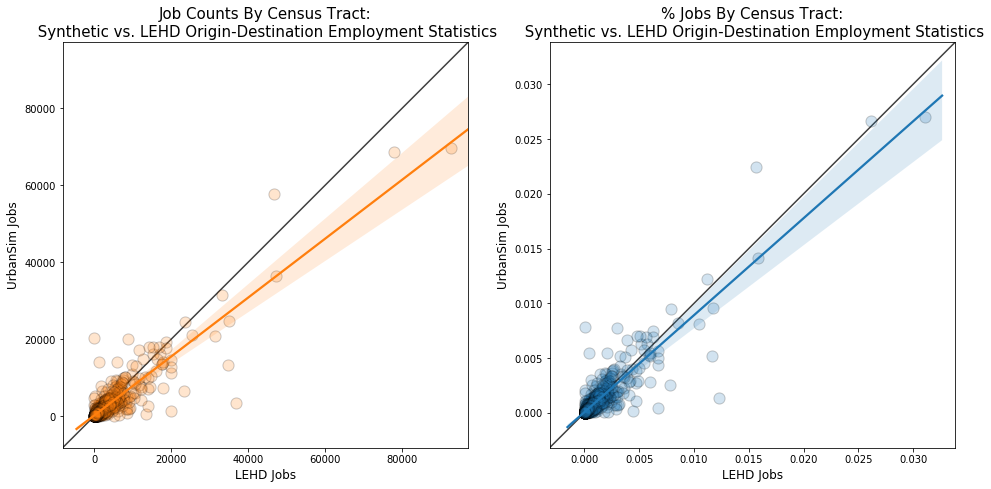

In [88]:
fig, axarr = plt.subplots(1, 2, figsize=(16,10))
ax1 = axarr[0]
ax2 = axarr[1]

sns.regplot(
    'pct_jobs_lodes', 'pct_jobs_synth', merged_job_tract_counts,
    ax=ax2, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_title(
    '% Jobs By Census Tract:\n Synthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax2.set_ylabel('UrbanSim Jobs', fontsize=12)
ax2.set_xlabel('LEHD Jobs', fontsize=12)

sns.regplot(
    'jobs_lodes', 'jobs_synth', merged_job_tract_counts,
    ax=ax1, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_title(
    'Job Counts By Census Tract:\n Synthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax1.set_ylabel('UrbanSim Jobs', fontsize=12)
ax1.set_xlabel('LEHD Jobs', fontsize=12)



Text(0.5, 0, 'LEHD Jobs')

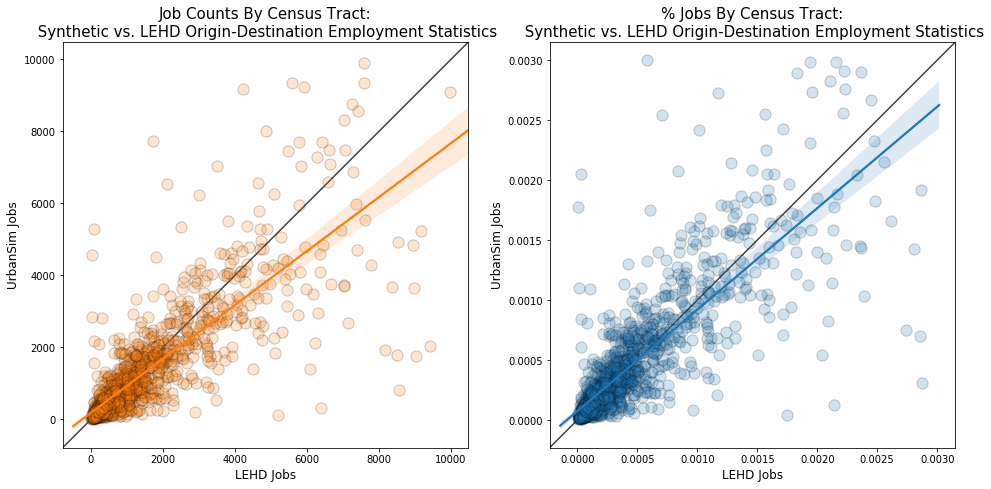

In [97]:
fig, axarr = plt.subplots(1, 2, figsize=(16,10))
ax1 = axarr[0]
ax2 = axarr[1]

sns.regplot(
    'pct_jobs_lodes', 'pct_jobs_synth', merged_job_tract_counts[
        (merged_job_tract_counts['pct_jobs_synth'] < 0.003) &
        (merged_job_tract_counts['pct_jobs_lodes'] < 0.003)
    ],
    ax=ax2, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_title(
    '% Jobs By Census Tract:\n Synthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax2.set_ylabel('UrbanSim Jobs', fontsize=12)
ax2.set_xlabel('LEHD Jobs', fontsize=12)
# ax2.set_xlim(-0.0001, 0.003)
# ax2.set_ylim(-0.0001, 0.003)

sns.regplot(
    'jobs_lodes', 'jobs_synth', merged_job_tract_counts[
        (merged_job_tract_counts['jobs_synth'] < 10000) &
        (merged_job_tract_counts['jobs_lodes'] < 10000)
    ],
    ax=ax1, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_title(
    'Job Counts By Census Tract:\n Synthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax1.set_ylabel('UrbanSim Jobs', fontsize=12)
ax1.set_xlabel('LEHD Jobs', fontsize=12)
# ax1.set_xlim(-500, 10000)
# ax1.set_ylim(-500, 10000)

/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Census Tract Job Counts: \n (LODES Jobs - UrbanSim Jobs) / LODES Jobs')

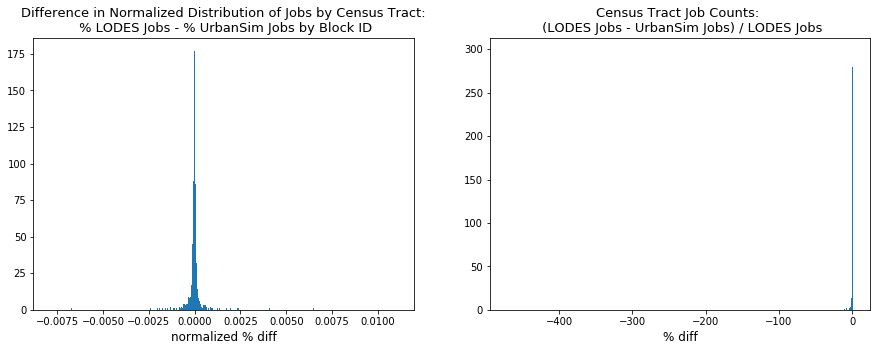

In [34]:
fig, axarr = plt.subplots(1,2, figsize=(15,5))

_ = axarr[0].hist(merged_job_tract_counts['normed_pct_diff'], bins=1000)
axarr[0].set_xlabel('normalized % diff', fontsize=12)
axarr[0].set_title('Difference in Normalized Distribution of Jobs by Census Tract:\n '
            '% LODES Jobs - % UrbanSim Jobs by Block ID', fontsize=13)
# axarr[0].set_xlim(-0.0004, 0.0001)

_ = axarr[1].hist(merged_job_tract_counts['pct_diff'], bins=2500)
axarr[1].set_xlabel('% diff', fontsize=12)
axarr[1].set_title('Census Tract Job Counts: \n (LODES Jobs - UrbanSim Jobs) / LODES Jobs', fontsize=13)
# axarr[1].set_xlim(-4000,300)

In [35]:
import matplotlib.ticker as mtick

/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


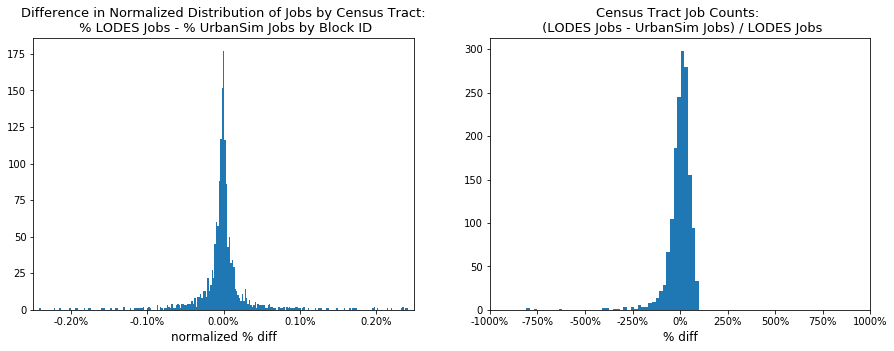

In [43]:
fig, axarr = plt.subplots(1,2, figsize=(15,5))

_ = axarr[0].hist(merged_job_tract_counts['normed_pct_diff'], bins=1000)
axarr[0].set_xlabel('normalized % diff', fontsize=12)
axarr[0].set_title('Difference in Normalized Distribution of Jobs by Census Tract:\n '
            '% LODES Jobs - % UrbanSim Jobs by Block ID', fontsize=13)
axarr[0].set_xlim(-0.0025, 0.0025)
axarr[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

_ = axarr[1].hist(merged_job_tract_counts['pct_diff'], bins=2500)
axarr[1].set_xlabel('% diff', fontsize=12)
axarr[1].set_title('Census Tract Job Counts: \n (LODES Jobs - UrbanSim Jobs) / LODES Jobs', fontsize=13)
axarr[1].set_xlim(-10, 10)
axarr[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [32]:
merged_job_tract_counts.sort_values('pct_diff').head()

,jobs_lodes,pct_jobs_lodes,jobs_synth,pct_jobs_synth,pct_diff,normed_pct_diff
tract,,,,,,
06001422600,43.0,0.000014,20286.0,0.007869,-470.767442,-0.007854
06095980000,27.0,0.000009,4582.0,0.001777,-168.703704,-0.001768
06085500902,44.0,0.000015,2834.0,0.001099,-63.409091,-0.001085
06001405700,99.0,0.000033,5290.0,0.002052,-52.434343,-0.002019
06013375000,83.0,0.000028,2174.0,0.000843,-25.192771,-0.000815


# Compare Distribution of "Commute" Flows _after_ WLCM

#### LEHD Flows

In [3]:
lodes_ods = pd.read_csv(
    '../../fall-2018-models/data/ca_od_main_JT01_2011.csv.gz',
    dtype={'w_geocode': str, 'h_geocode': str}, usecols=['w_geocode', 'h_geocode', 'S000'],
    compression='gzip')

lodes_ods['tract_id_h'] = lodes_ods['h_geocode'].str[0:11]
lodes_ods['tract_id_w'] = lodes_ods['w_geocode'].str[0:11]
lodes_od_tract_counts = lodes_ods[['tract_id_h', 'tract_id_w', 'S000']].groupby(
    ['tract_id_h', 'tract_id_w']).sum().reset_index().rename(columns={'S000': 'count'})

In [4]:
lodes_od_tract_counts.head()

,tract_id_h,tract_id_w,count
0,06001400100,06001400100,91
1,06001400100,06001400200,4
2,06001400100,06001400300,2
3,06001400100,06001400400,4
4,06001400100,06001400700,1


#### Synthetic Flows

In [5]:
persons_w_jobs = pd.read_csv('../../fall-2018-models/data/persons_w_jobs_2018_10_26.csv', index_col='person_id')

/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
persons_w_jobs.head()

,member_id,age,primary_commute_mode,relate,edu,sex,hours,hispanic,earning,race_id,student,work_at_home,worker,household_id,job_id,node_id_small,node_id_walk
person_id,,,,,,,,,,,,,,,,,
0,1,47,1.0,0,22.0,1,40.0,1,85000.0,1,0,0,1,0,911412.0,6.546892e+07,5.125306e+09
1,1,47,1.0,0,22.0,1,40.0,1,85000.0,1,0,0,1,670,NaN,2.861307e+08,5.265128e+09
2,1,47,1.0,0,22.0,1,40.0,1,85000.0,1,0,0,1,740,573269.0,2.279076e+09,2.860970e+08
3,1,47,1.0,0,22.0,1,40.0,1,85000.0,1,0,0,1,975,52739.0,3.969451e+09,6.546673e+07
4,1,47,1.0,0,22.0,1,40.0,1,85000.0,1,0,0,1,977,258057.0,6.561551e+07,6.554853e+07


In [7]:
jobs = store['jobs']
bldgs = store['buildings']
parcels = store['parcels']
households = store['households']
units = store['units']
buildings = store['buildings']

In [8]:
df_home_fips = persons_w_jobs.merge(households[['building_id']], left_on='household_id', right_index=True).merge(
    buildings[['parcel_id']], left_on='building_id', right_index=True).merge(
    parcels[['block_id']], left_on='parcel_id', right_index=True)[['block_id']]

In [9]:
df_work_fips = persons_w_jobs.merge(jobs[['building_id']], left_on='job_id', right_index=True).merge(
    buildings[['parcel_id']], left_on='building_id', right_index=True).merge(
    parcels[['block_id']], left_on='parcel_id', right_index=True)[['block_id']]

In [10]:
del jobs, bldgs, parcels, households, units, buildings

In [11]:
merged = pd.merge(df_home_fips, df_work_fips, left_index=True, right_index=True, suffixes=('_home', '_work'))

In [12]:
merged['tract_id_h'] = merged['block_id_home'].str[0:11]
merged['tract_id_w'] = merged['block_id_work'].str[0:11]

In [13]:
wlcm_od_tract_counts = merged[['tract_id_h', 'tract_id_w']].reset_index().groupby(['tract_id_h', 'tract_id_w']).count().reset_index().rename(columns={'person_id': 'count'})

#### Merge LODES and WLCM Flows

In [14]:
merged_od_tract_counts = pd.merge(
    wlcm_od_tract_counts, lodes_od_tract_counts, on=['tract_id_h', 'tract_id_w'], suffixes=('_wlcm', '_lodes'))

In [15]:
merged_od_tract_counts.head()

,tract_id_h,tract_id_w,count_wlcm,count_lodes
0,06001400100,06001400100,2,91
1,06001400100,06001400200,1,4
2,06001400100,06001400300,1,2
3,06001400100,06001400700,1,1
4,06001400100,06001401000,2,10


In [16]:
merged_od_tract_counts['pct_wlcm'] = merged_od_tract_counts['count_wlcm'] / merged_od_tract_counts['count_wlcm'].sum()
merged_od_tract_counts['pct_lodes'] = merged_od_tract_counts['count_lodes'] / merged_od_tract_counts['count_lodes'].sum()
merged_od_tract_counts['normed_pct_diff'] = merged_od_tract_counts['pct_lodes'] - merged_od_tract_counts['pct_wlcm']
merged_od_tract_counts['pct_diff'] = (
    merged_od_tract_counts['count_lodes'] - merged_od_tract_counts['count_wlcm']) / merged_od_tract_counts['count_lodes']

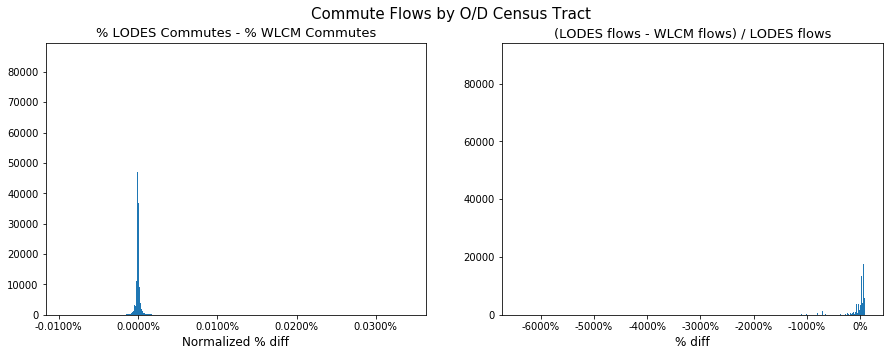

In [85]:
fig, axarr = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Commute Flows by O/D Census Tract', fontsize=15)

_ = axarr[0].hist(merged_od_tract_counts['normed_pct_diff'], bins=1000)
axarr[0].set_xlabel('Normalized % diff', fontsize=12)
axarr[0].set_title('% LODES Commutes - % WLCM Commutes', fontsize=13)
axarr[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

_ = axarr[1].hist(merged_od_tract_counts['pct_diff'], bins=1000)
axarr[1].set_xlabel('% diff', fontsize=12)
_ = axarr[1].set_title('(LODES flows - WLCM flows) / LODES flows', fontsize=13)
axarr[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

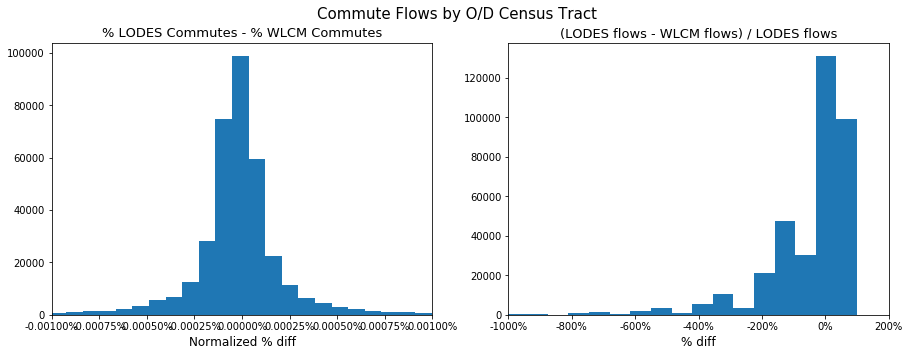

In [86]:
fig, axarr = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Commute Flows by O/D Census Tract', fontsize=15)

_ = axarr[0].hist(merged_od_tract_counts['normed_pct_diff'], bins=500)
axarr[0].set_xlabel('Normalized % diff', fontsize=12)
axarr[0].set_title('% LODES Commutes - % WLCM Commutes', fontsize=13)
axarr[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axarr[0].set_xlim(-0.00001, 0.00001)

_ = axarr[1].hist(merged_od_tract_counts['pct_diff'], bins=100)
axarr[1].set_xlabel('% diff', fontsize=12)
_ = axarr[1].set_title('(LODES flows - WLCM flows) / LODES flows', fontsize=13)
axarr[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
_ = axarr[1].set_xlim(-10, 2)

(0, 300)

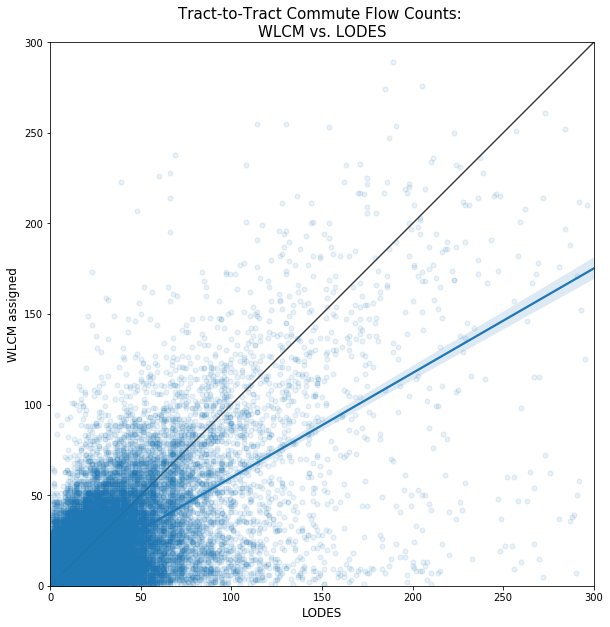

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(
    'count_lodes', 'count_wlcm', merged_od_tract_counts,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 100, "marker":'o', "alpha": 0.1})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Tract-to-Tract Commute Flow Counts: \nWLCM vs. LODES', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)
ax.set_xlim(0,300)
ax.set_ylim(0,300)